# Debugging Benchmark Failures

In [11]:
import pathlib
import typing

import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

from labm8.py import pbutil
from labm8.py import viz
from labm8.py import labdate
from labm8.py import labtypes
from labm8.py import prof

from gpu.libcecl.proto import libcecl_pb2
from datasets.benchmarks.gpgpu import gpgpu_pb2

In [13]:
# LOGDIR = pathlib.Path('/var/phd/shared/datasets/benchmarks/gpgpu/logs')
LOGDIR = pathlib.Path('/var/phd/shared/datasets/benchmarks/gpgpu/logs')
assert LOGDIR.is_dir()
!echo $(ls {LOGDIR} | wc -l) files

455 files


In [14]:
with prof.ProfileToStdout():
    logs = [pbutil.FromFile(log, gpgpu_pb2.GpgpuBenchmarkRun())
                            for log in LOGDIR.iterdir()]

completed in 2.149 seconds (started 2 seconds ago)


In [15]:
error_logs = [log for log in logs if log.run.returncode]
print(len(error_logs), 'of', len(logs), 'failed')

185 of 455 failed


In [72]:
df = pd.DataFrame([
    (log.benchmark_suite, log.benchmark_name, log.dataset_name, log.run.device.name, log.run.returncode, log.run.stdout, log.run.stderr)
    for log in error_logs
], columns = ['suite', 'benchmark', 'dataset', 'device', 'returncode', 'stdout', 'stderr'])
df.sort_values(['suite','benchmark','dataset', 'device'], inplace=True)
df.reset_index(drop=True, inplace=True)

def ConstructDeviceNameTranslationMap(strings):
    strings = set(strings)
    for i in range(4):
        candidates = {'|'.join(x.split('|')[:i]) for x in strings}
        if len(candidates) == len(strings):
            return {
                x: '|'.join(x.split('|')[:i]) for x in strings
            }

device_name_translation_map = ConstructDeviceNameTranslationMap(df['device'])
df['device'] = [device_name_translation_map[d] for d in df['device']]

df

,suite,benchmark,dataset,device,returncode,stdout,stderr
0,amd-app-sdk-3.0,AdvancedConvolution,default,GPU,1,Platform 0 : NVIDIA Corporation\nPlatform 1 : ...,
1,amd-app-sdk-3.0,AdvancedConvolution,default,GPU,1,Platform 0 : NVIDIA Corporation\nPlatform 1 : ...,
2,amd-app-sdk-3.0,AdvancedConvolution,default,GPU,1,Platform 0 : NVIDIA Corporation\nPlatform 1 : ...,
3,amd-app-sdk-3.0,Histogram,default,GPU,101,Platform 0 : NVIDIA Corporation\nPlatform 1 : ...,
4,amd-app-sdk-3.0,Histogram,default,GPU,101,Platform 0 : NVIDIA Corporation\nPlatform 1 : ...,
5,amd-app-sdk-3.0,Histogram,default,GPU,101,Platform 0 : NVIDIA Corporation\nPlatform 1 : ...,
6,dummy_just_for_testing,hello,default,CPU,1,Error: Failed to create a device group!\n,
7,dummy_just_for_testing,hello,default,GPU,1,Error: Failed to create a device group!\n,
8,npb-3.3,bt.A,A,CPU,-11,,
9,npb-3.3,bt.B,B,CPU,-11,,


In [71]:
idx = 155
print(df.iloc[idx].stderr)
print("STDOUT ===============")
print(df.iloc[idx].stdout)

Number of Platforms found: 4
Number of Devices found for Platform 0: 2
Chose Device Type: CPU
Number of Platforms found: 4
Number of Devices found for Platform 0: 2
Chose Device Type: CPU
there is a failure to build the program executable. This error will be returned if clBuildProgram does not return until the build has completed.
make: *** [run] Error 101
STDOUT ===============
Resolving OpenCL library...
LD_LIBRARY_PATH=:/home/cec/.cache/bazel/_bazel_cec/d1665aef25bbeeb91c01df7ddc90dba7/execroot/phd/bazel-out/k8-fastbuild/bin/datasets/benchmarks/gpgpu/gpgpu.runfiles/phd/gpu/libcecl ldd build/opencl_base_default/mri-gridding | grep OpenCL
	libOpenCL.so => /home/cec/.cache/bazel/_bazel_cec/d1665aef25bbeeb91c01df7ddc90dba7/execroot/phd/bazel-out/k8-fastbuild/bin/datasets/benchmarks/gpgpu/gpgpu.runfiles/libopencl/libOpenCL.so (0x00007fddf2bd1000)
	libOpenCL.so.1 => /usr/local/cuda-9.0/targets/x86_64-linux/lib/libOpenCL.so.1 (0x00007fddf193c000)
LD_LIBRARY_PATH=:/home/cec/.cache/bazel/_ba

In [55]:
df[df['device'] == 'CPU']

,suite,benchmark,dataset,device,returncode,stdout,stderr
3,npb-3.3,bt.B,B,CPU,-11,,
6,npb-3.3,bt.W,W,CPU,-11,,
8,parboil-0.2,spmv.large,default,CPU,1,Resolving OpenCL library...\nLD_LIBRARY_PATH=:...,make: *** [run] Error 1
9,rodinia-3.1,hotspot3D,default,CPU,127,,./run: line 1: ./hotspot3D: No such file or di...
12,shoc-1.1.5,GEMM,default,CPU,1,,OpenCLDeviceInfo.cpp:1302: CL_DEVICE_NOT_FOUND
14,parboil-0.2,sad.large,default,CPU,1,Resolving OpenCL library...\nLD_LIBRARY_PATH=:...,OpenCL Error (src/opencl_base/OpenCL_common.cp...
15,polybench-gpu-1.0,ATAX,default,CPU,-11,,
16,parboil-0.2,lbm.short,default,CPU,1,Resolving OpenCL library...\nLD_LIBRARY_PATH=:...,make: *** [run] Error 1
17,polybench-gpu-1.0,SYR2K,default,CPU,-11,,
24,nvidia-4.2,RadixSort,default,CPU,255,[oclRadixSort] starting...\n\n/tmp/phd_dataset...,


In [54]:
df[(df['suite'] == 'npb-3.3') & (df['device'] == 'CPU')]

,suite,benchmark,dataset,device,returncode,stdout,stderr
3,npb-3.3,bt.B,B,CPU,-11,,
6,npb-3.3,bt.W,W,CPU,-11,,
28,npb-3.3,mg.C,C,CPU,-11,,
29,npb-3.3,ft.C,C,CPU,-11,,
31,npb-3.3,cg.S,S,CPU,-11,,
32,npb-3.3,is.S,S,CPU,-11,,
36,npb-3.3,mg.B,B,CPU,-11,,
43,npb-3.3,ep.B,B,CPU,-11,,
53,npb-3.3,lu.B,B,CPU,-11,,
55,npb-3.3,mg.S,S,CPU,-11,,


In [22]:
idx = 1
print(df.iloc[1].stderr)
print("STDOUT ===============")
print(df.iloc[1].stdout)


STDOUT ===============
Sorting list of 1000000 floats.
Error: Failed to create a device group!



,suite,device,count
0,amd-app-sdk-3.0,GPU,6
1,dummy_just_for_testing,CPU,1
2,dummy_just_for_testing,GPU,1
3,npb-3.3,CPU,39
4,npb-3.3,GPU,10
5,nvidia-4.2,CPU,14
6,nvidia-4.2,GPU,24
7,parboil-0.2,CPU,25
8,parboil-0.2,GPU,20
9,polybench-gpu-1.0,CPU,14


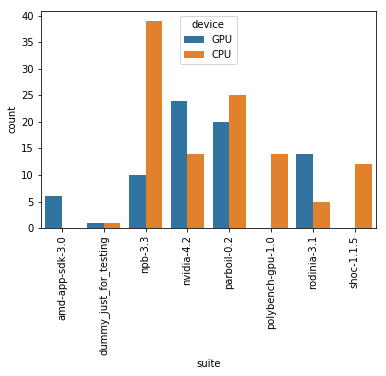

In [50]:
summary = df.groupby(['suite', 'device']).count().rename(columns={'benchmark': 'count'})[['count']].reset_index()
sns.barplot(x='suite', y='count', hue='device', data=summary)
viz.RotateXLabels()
summary

In [9]:
l = error_logs[1].run
print(l.stdout)
print(l.stderr)

ms_since_unix_epoch: 1551446700964
returncode: 101
cecl_log: "clCreateCommandQueue ; GPU ; GeForce GTX 1080\nclCreateBuffer ; 4194304 ; NULL ; CL_MEM_READ_ONLY\nclCreateBuffer ; 65536 ; NULL ; CL_MEM_WRITE_ONLY\nclCreateKernel ; program ; histogram256_scalar\nclEnqueueMapBuffer ; deviceBuffer ; 4194304 ; 0.000000\nclSetKernelArg ; histogram256_scalar ; 0 ; 8 ; (void*)&dataBuf\nclSetKernelArg ; histogram256_scalar ; 1 ; 32768 ; NULL\nclSetKernelArg ; histogram256_scalar ; 2 ; 8 ; (void*)&midDeviceBinBuf\nERROR: clWaitForEvents() failed! Cause:"
stdout: "Platform 0 : NVIDIA Corporation\nPlatform 1 : The pocl project\nPlatform 2 : Intel(R) Corporation\nPlatform 3 : Codeplay Software Ltd.\nPlatform found : NVIDIA Corporation\n\nSelected Platform Vendor : NVIDIA Corporation\nDevice 0 : GeForce GTX 1080 Device ID is 0x212c890\nDevice 1 : GeForce GTX 1080 Device ID is 0x212c920\nSelecting scalar kernel\n\nExecuting kernel for 1 iterations\n-------------------------------------------\n"
stderr

Platform 0 : NVIDIA Corporation
Platform 1 : The pocl project
Platform 2 : Intel(R) Corporation
Platform 3 : Codeplay Software Ltd.
Platform found : NVIDIA Corporation

Selected Platform Vendor : NVIDIA Corporation
Device 0 : GeForce GTX 1080 Device ID is 0x212c890
Device 1 : GeForce GTX 1080 Device ID is 0x212c920
Selecting scalar kernel

Executing kernel for 1 iterations
-------------------------------------------


